<h1>Audio</h1>

Wieso sind Töne und Geräusche wichtig?<br>
Auch diese können wie normale Daten wie Text oder Bilder mit einem neuralen Netz verarbeitet werden. Neurale Netze sind dafür sehr gut geeignet, diese können verschiedenste Features erfassen anders als die einfacheren Machine Learning Konzepte. Besonders wenn es komplexere Zusammenhänge gibt wie bei Bildern.

Es gibt unterschiedlichste Use-Cases wie:
- Spracherkennung (Wörter, Befehle, Audio-to-text)
- Klassifizierung von Tönen wie Musik.
- Umgebungswahrnehmung
- Geräusche differenzieren und Unterschiede erkennen

Um den Anfang zu machen, wollen wir als Ziel ein Model trainieren, dass Wörter erkennen soll.:
- Ein ASR Model (Automatic-speech-recognition)

Als Dataset nutzen wir:
> Speech Commands dataset (Warden, 2018) <br>
> https://www.tensorflow.org/datasets/catalog/speech_commands [Letzter Zugriff: 12.08.2024]

Dieses Dataset enthält folgende Wörter im Audioformat: "down", "go", "left", "no", "right", "stop", "up" und "yes"

In [2]:
# Imports 
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import IPython
from IPython import display

In [2]:
tf.__version__

'2.17.0'

Dan laden wir das Dataset herunter.

In [3]:
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

In [4]:
# Dataset enthält Ordner mit Audiodateien.
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print(f'Kommandos: {commands}')

Kommandos: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Jeder dieser Ordner enthält .wav Audiodateien, die wir abspielen können.
- Durch solch eine Ordnerstruktur kann direkt mit TensorFlow ein Dataset erstellt werden. Siehe TF Datasets.

<h2>Spiele Audiodatei ab</h2>

In [5]:
# Erstelle Liste mit Dateinamen.
files_names_down = os.listdir(os.path.join(DATASET_PATH, "down"))
len(files_names_down)

1000

In [8]:
files_names_down[0]

'004ae714_nohash_0.wav'

Audiodateien könne im Notebook über IPython oder HTML einfach abgespielt werden.

In [6]:
IPython.display.Audio("data/mini_speech_commands/down/004ae714_nohash_0.wav")

In [7]:
# Spiele verschiedene Dateien ab #
# Down # 
rdm = np.random.randint(1, len(files_names_down))
audo_file = DATASET_PATH+"/down/"
print("File: Down")
IPython.display.Audio(audo_file+files_names_down[rdm])

File: Down


In [8]:
# Spiele verschiedene Dateien ab #

categ = commands[np.random.randint(1, len(commands))]
index = np.random.randint(1, len(files_names_down))

categ_path     = DATASET_PATH+f"/{categ}"
list_categ_dir = os.listdir(categ_path)

audo_file = categ_path+f"/{list_categ_dir[index]}"

print(f"File: {audo_file}\nCommando: {categ}")
IPython.display.Audio(audo_file)

File: data/mini_speech_commands/yes/6094340e_nohash_0.wav
Commando: yes


<h2>Erstelle Dataset</h2>

Mit TensorFlow kann aus einem Verzeichnis direkt ein Dataset abgeleitet werden. Das vereinfach den Umgang mit den Daten.
- Siehe TF Datasets.

In [5]:
# Erstelle Dataset # 
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=32,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')
train_ds

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.


<_BatchDataset element_spec=(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [139]:
dir(train_ds)

['_GeneratorState',
 '__abstractmethods__',
 '__bool__',
 '__class__',
 '__class_getitem__',
 '__debug_string__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__nonzero__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__tf_tracing_type__',
 '__weakref__',
 '_abc_impl',
 '_add_trackable_child',
 '_add_variable_with_custom_getter',
 '_apply_debug_options',
 '_as_serialized_graph',
 '_batch_size',
 '_checkpoint_adapter',
 '_checkpoint_dependencies',
 '_common_args',
 '_consumers',
 '_convert_variables_to_tensors',
 '_copy_trackable_to_cpu',
 '_deferred_dependencies',
 '_deserialization_dependencies',
 '_deserialize_from_proto',
 '_drop_remainder',
 '_export_to_saved_model_graph',
 '_flat_shapes',
 '_f

In [6]:
label_names = train_ds.class_names
train_ds.class_names

['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']

In [7]:
# Entferne eine Achse, da Single-Channel # 
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds   = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [8]:
# Erstelle Test- und Validationset #
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds  = val_ds.shard(num_shards=2, index=1)

<h2>Eigene Aufnahmen</h2>

Um Dataset oder Daten für die Prediction zu erstellen, können wir verschiedene Methoden anwenden.

Für sounddevice: <br> 
> https://python-sounddevice.readthedocs.io/en/0.3.15/api/checking-hardware.html [Letzter Zugriff: 19.08.2024]

In [9]:
import sounddevice as sd
from scipy.io.wavfile import write
import wavio as wv

In [25]:
# Frequenz: 
freq = 44100
# Aufnahmezeit: 
record_time = 5

In [30]:
sd.query_devices(kind="input")

{'name': 'Mikrofon (USB Condenser Microph',
 'index': 1,
 'hostapi': 0,
 'max_input_channels': 1,
 'max_output_channels': 0,
 'default_low_input_latency': 0.09,
 'default_low_output_latency': 0.09,
 'default_high_input_latency': 0.18,
 'default_high_output_latency': 0.18,
 'default_samplerate': 44100.0}

In [52]:
# Aufnahme #
# - channels: 1 oder 2.
recording = \
    sd.rec(int(record_time * freq), samplerate=freq, channels=1)          
sd.wait()

In [53]:
recording

array([[0.00283813],
       [0.00335693],
       [0.00271606],
       ...,
       [0.00234985],
       [0.01815796],
       [0.0140686 ]], dtype=float32)

In [54]:
# Speichere # 
write("./data/data/recording0.wav", freq, recording)

In [58]:
# Mit wavio # 
wv.write("./data/data/recording0.wav", recording, freq, sampwidth=2)

Danach können wir die Audiodatei laden und beliebig nutzen.

In [57]:
# Playback: 
sd.play(recording, freq)
sd.wait()

In [39]:
# Kann auch heruntergeladen werden # 
IPython.display.Audio("./data/data/recording0.wav")

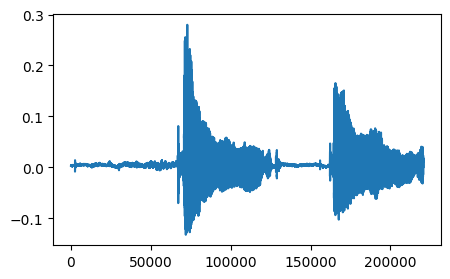

In [55]:
plt.figure(figsize=(5,3))
plt.plot(recording)

<h2>Visualisierung und weiteres zu Audioformaten</h2>

Wie oben zusehen ist, können Audiodateien visuell dargestellt werden.

In [10]:
example_audio_signals = []
example_audio_labels  = []
for example_audio, example_labels in train_ds.take(1):  
      print(example_audio.shape)
      print(example_labels.shape)
      example_audio_signals.append(example_audio)
      example_audio_labels.append(example_labels)

(32, 16000)
(32,)


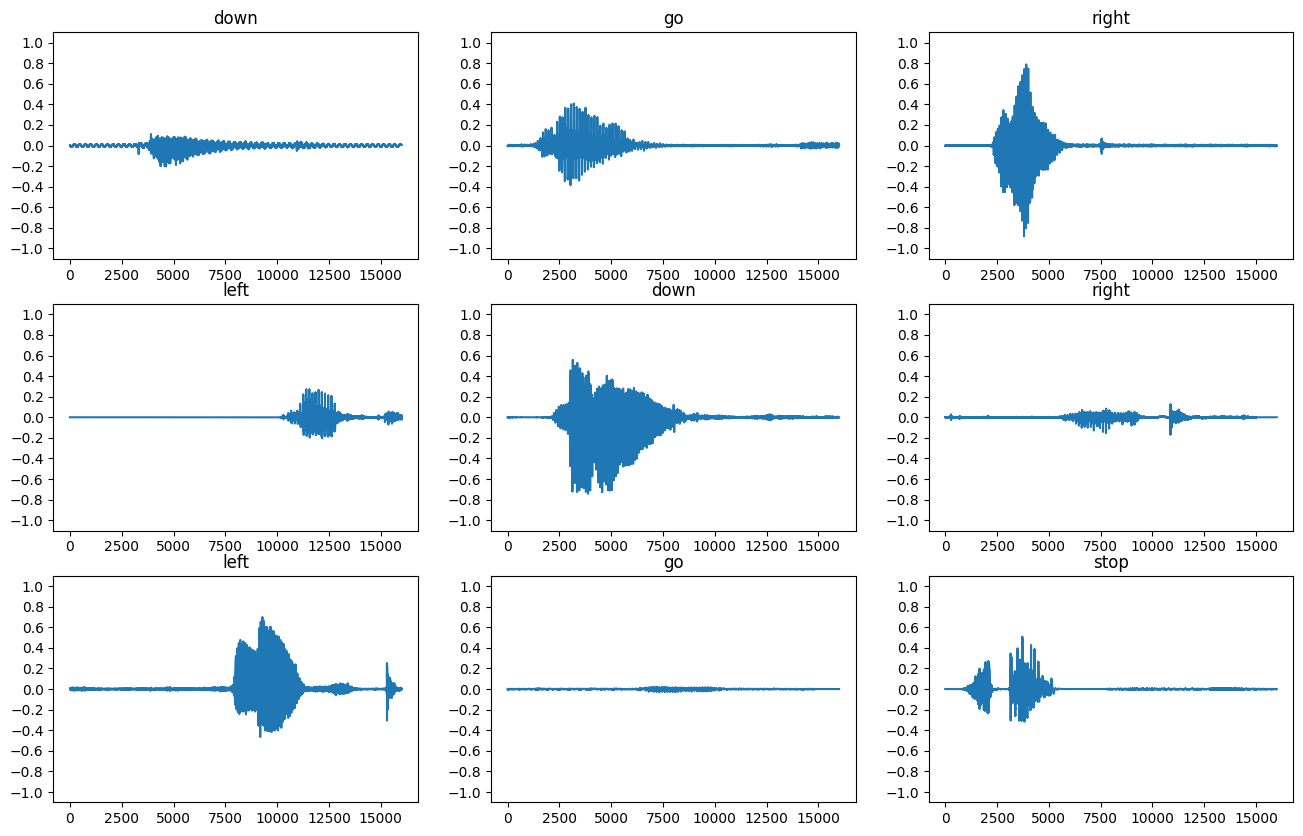

In [11]:
# Plote Dataset # 
plt.figure(figsize=(16, 10))

for i in range(9):
      plt.subplot(3, 3, i+1)
      audio_signal = example_audio_signals[0][i]
      plt.plot(audio_signal)
      plt.title(label_names[example_audio_labels[0][i]])
      plt.yticks(np.arange(-1.2, 1.2, 0.2))
      plt.ylim([-1.1, 1.1])

Für das spätere Training müssen die Daten von dem Waveform Format in ein anderes Format (STFT) überführt werden. <br>
STFT steht für short-time Fourier Transform, damit werden die .wav Dateien in eine Spektrogramm-Form gebracht, welche auch als 2D-Bild dargestellt werden kann. Dieses Format zeigt die Änderung der Frequenz über Zeit.

Für die Transformation bietet TensorFlow eigene Methoden.
- tf.signal.fft: Konvertiert das Audiosignal in Bestandteile, keine Zeitinformation
- tf.signal.stft: Teile Audiosignal in Fenster auf
  
Beide führen eine Fourier transformation aus. 

Wenn Audioclips sehr kurz sind, sollte ein Padding genutzt werden.

In [15]:
# Erstelle Spektrogramm #  
def get_spectrogram(waveform):
      spectrogram = tf.signal.stft(
          waveform, frame_length=255, frame_step=128)
      # Magnitude 
      spectrogram = tf.abs(spectrogram)
      # Füge Channel hinzu. Später für Faltungsnetz # 
      spectrogram = spectrogram[..., tf.newaxis]
      return spectrogram

In [16]:
for i in range(2):
      label = label_names[ example_audio_labels[0][i]]
      waveform =  example_audio_signals[0][i]
      spectrogram = get_spectrogram(waveform)

      print('Label:', label)
      print('Waveform shape:', waveform.shape)
      print('Spektrogramm shape:', spectrogram.shape)
      print('Audio playback')
      display.display(display.Audio(waveform, rate=16000))

Label: down
Waveform shape: (16000,)
Spektrogramm shape: (124, 129, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spektrogramm shape: (124, 129, 1)
Audio playback


Das Spektrogramm zu einem gegebenen Audiosignal können wir auch Ploten.

In [13]:
def plot_spectrogram(spectrogram, ax):
      if len(spectrogram.shape) > 2:
            assert len(spectrogram.shape) == 3
      spectrogram = np.squeeze(spectrogram, axis=-1)
      # Frequenz zu Logskalar- Zeit als X-Achse.
      # - Epsilon, damit Log keine 0 erhählt. 
      log_spec = np.log(spectrogram.T + np.finfo(float).eps)
      height = log_spec.shape[0]
      width = log_spec.shape[1]
      X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
      Y = range(height)
      ax.pcolormesh(X, Y, log_spec)

NameError: name 'waveform' is not defined

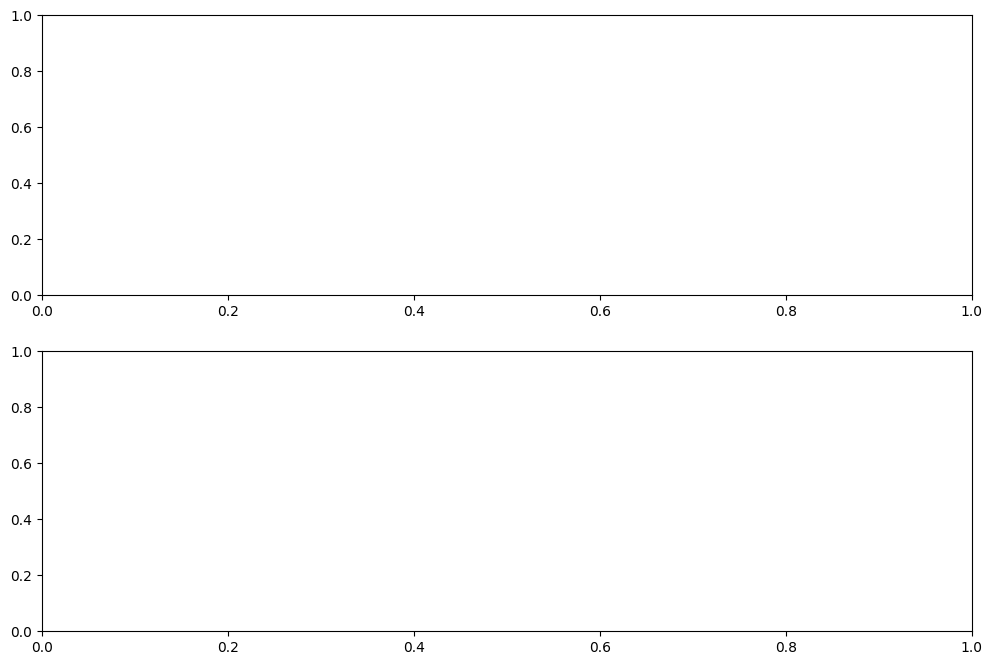

In [14]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Damit erstellen wir das Dataset.

In [17]:
# Forme Waveform in Spektrogramm um. # 
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [18]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds   = make_spec_ds(val_ds)
test_spectrogram_ds  = make_spec_ds(test_ds)

Nach der Umformung werden die verschiedenen Datensätze als Spektrogramm angezeigt.

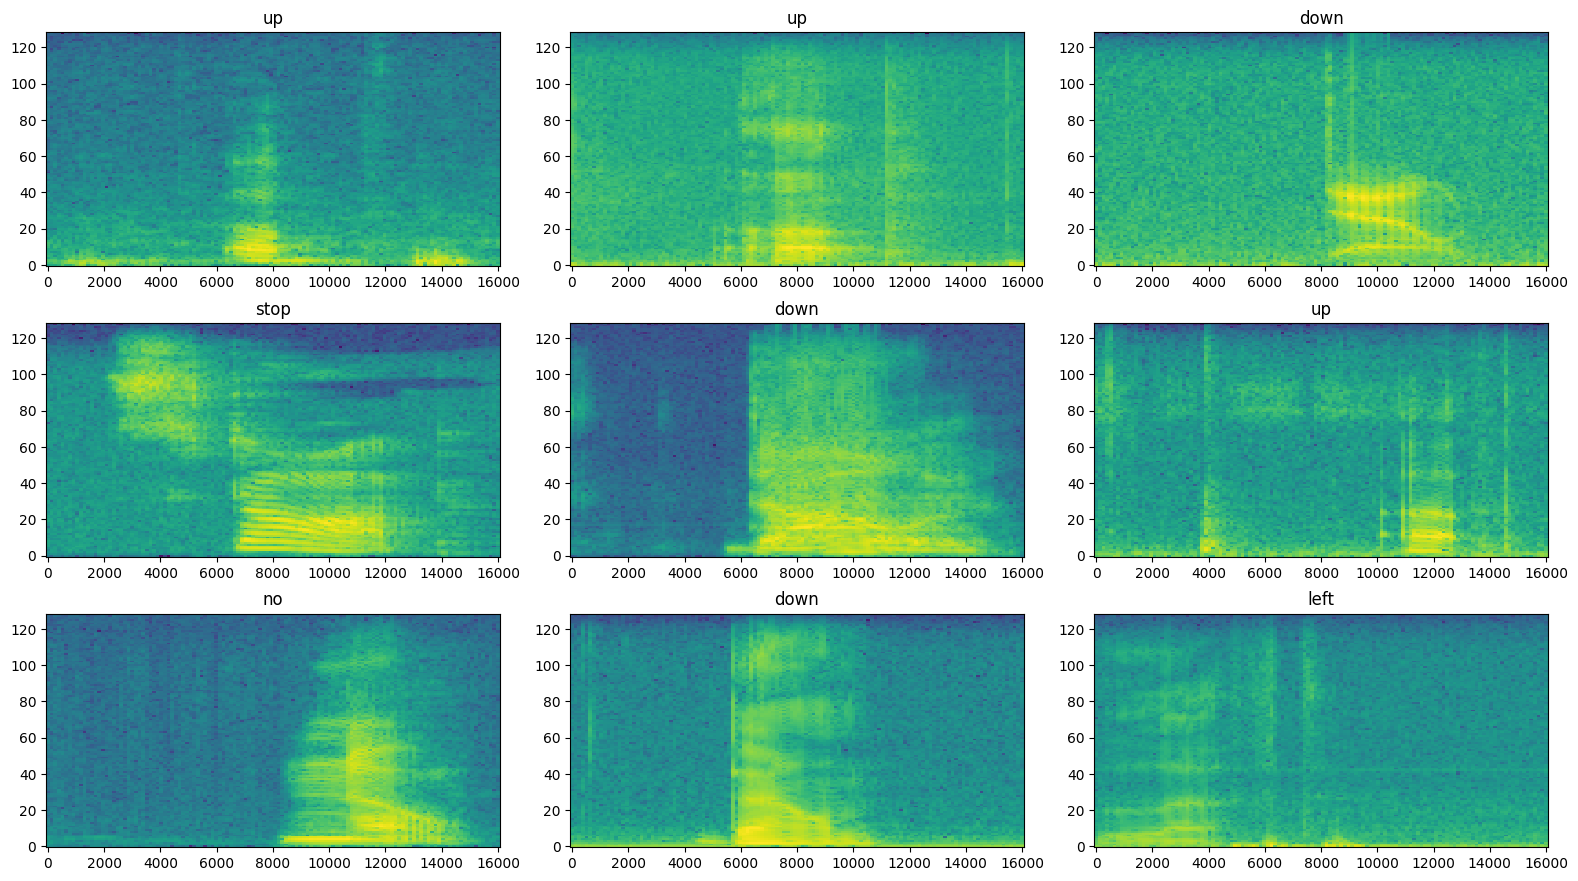

In [20]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

rows = 3
cols = 3
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))
fig.tight_layout(pad=2)
for i in range(9):
    r = i // 3
    c = i % 3
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

Für die <u>Data-Argumentation</u> von Audiodateien kann z. B. Rauschen eingefügt werden.
- Beachte dabei weitere Konzepte wie Normalisierung, etc.

In [149]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds   = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds  = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

Damit ist das Dataset bereit.

<h2>Model</h2>

Jetzt muss ein passendes Model erstellt werden. Ein Model, das nur aus einfachen Neuronen besteht, kann nicht komplexere Features abdecken wie das bei Bildern der Fall ist.

In [151]:
input_shape = example_spectrograms.shape[1:]
input_shape

TensorShape([124, 129, 1])

In [153]:
num_labels = len(label_names)
num_labels

8

In [160]:
# Nutze Normalisierungslayer # 
norm_layer = tf.keras.layers.Normalization()
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))
norm_layer
# Model #
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=input_shape),
    tf.keras.layers.Resizing(32, 32),  # Downsampling

    norm_layer,
    tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(.4),
    tf.keras.layers.Dense(units=num_labels)
])

model.compile(
    optimizer = 'adam',
    loss      = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics   = ['accuracy']
) 

In [161]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_5 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,611 (6.20 MB)

 Trainable params: 1,625,608 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

<h2>Training und Eval.</h2>

In [162]:
history = model.fit(train_spectrogram_ds, validation_data=val_spectrogram_ds, epochs=12)

Epoch 1/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.3131 - loss: 1.8899 - val_accuracy: 0.6662 - val_loss: 1.0668
Epoch 2/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6397 - loss: 1.0557 - val_accuracy: 0.7400 - val_loss: 0.7947
Epoch 3/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.7543 - loss: 0.7144 - val_accuracy: 0.7912 - val_loss: 0.6137
Epoch 4/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.8033 - loss: 0.5667 - val_accuracy: 0.7788 - val_loss: 0.6066
Epoch 5/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8233 - loss: 0.4853 - val_accuracy: 0.8238 - val_loss: 0.5303
Epoch 6/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.8561 - loss: 0.4081 - val_accuracy: 0.8288 - val_loss: 0.4975
Epoch 7/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.8761 - loss: 0.3353 - val_accuracy: 0.8425 - val_loss: 0.4728
Epoch 8/12
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.8908 - loss: 0.3047 - val_accu

In [167]:
model.evaluate(test_spectrogram_ds, return_dict=True)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8664 - loss: 0.4983


{'accuracy': 0.8675000071525574, 'loss': 0.5234403014183044}

TensorFlow gibt direkt Rückmeldung wie das Training gelaufen ist. Damit können Visualisierungen schnell erstellt werden.

Text(0, 0.5, 'Accuracy [%]')

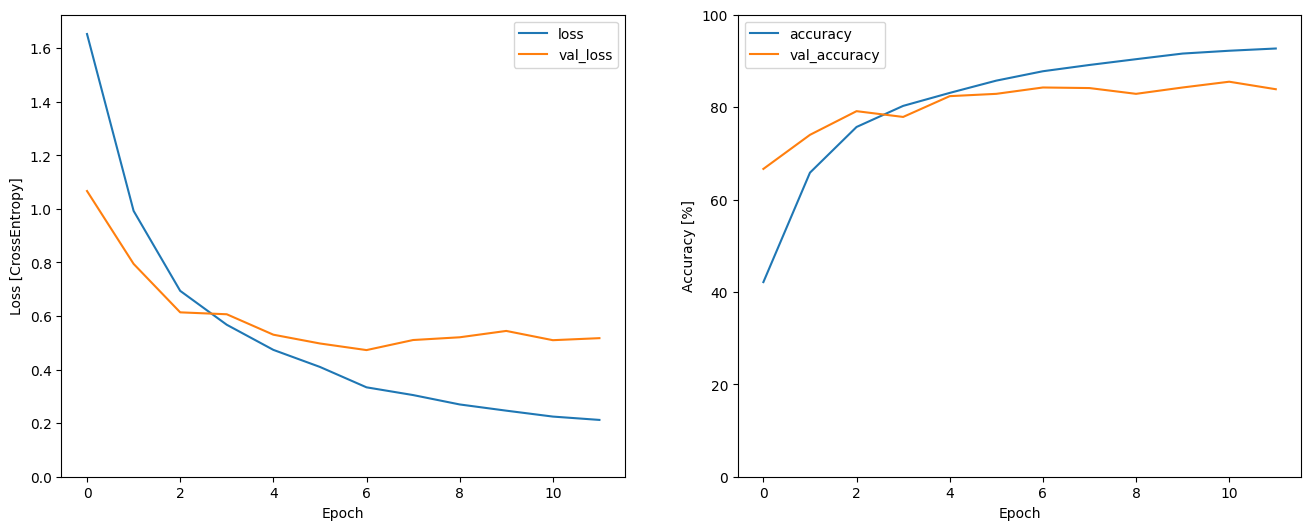

In [165]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

Erstelle Heat-Map.:

In [168]:
y_pred = model.predict(test_spectrogram_ds)
y_pred

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


array([[-17.235115  , -13.613883  ,   6.891355  , ...,   4.662943  ,
         20.229952  , -10.172951  ],
       [  0.12310855,  -0.25736633,   0.26456267, ...,  -3.7982695 ,
         -6.5874395 ,   3.7437978 ],
       [ -0.3241008 ,   0.33841836,  -0.9186225 , ...,  -0.44549906,
          0.08801079,  -0.49710593],
       ...,
       [  5.567224  ,   9.203691  ,  -8.525481  , ..., -13.7658615 ,
         -1.9984989 , -21.030416  ],
       [ -3.568158  ,  -1.3468376 ,  -3.0160851 , ...,   5.777702  ,
          3.1390388 ,  -3.388554  ],
       [ -9.213337  ,  -5.476189  ,   8.337949  , ...,  -2.8934534 ,
          0.38447866,   0.5993224 ]], dtype=float32)

In [170]:
len(y_pred[0])

8

In [172]:
# Index stellt Klasse dar. Welche hat höchste Energie?
# - Nuze Argmax.
y_pred = [np.argmax(x) for x in y_pred]

In [175]:
y_pred = np.array(y_pred)

In [176]:
y_pred.shape

(800,)

In [177]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

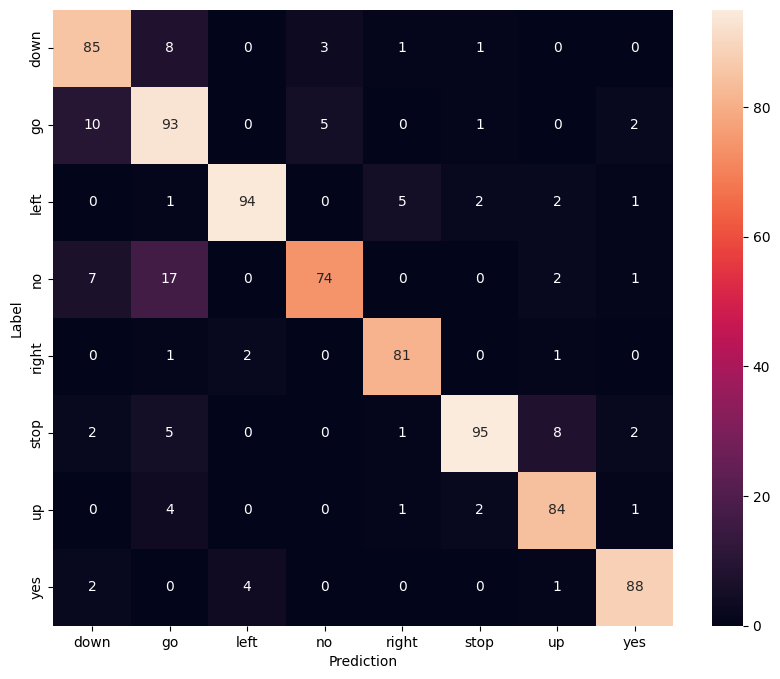

In [178]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [182]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83        98
           1       0.72      0.84      0.78       111
           2       0.94      0.90      0.92       105
           3       0.90      0.73      0.81       101
           4       0.91      0.95      0.93        85
           5       0.94      0.84      0.89       113
           6       0.86      0.91      0.88        92
           7       0.93      0.93      0.93        95

    accuracy                           0.87       800
   macro avg       0.87      0.87      0.87       800
weighted avg       0.87      0.87      0.87       800

